# This script processes SYCL and CUDA results 

1. Go to SYCL-CUDA directory and compile all versions with:
```
make
```
2. Run the benchmarking script
```
cd scripts
python3 run_sycl_cuda.py
```
3. The output that we will process is sycl_cuda_coffee.txt (renamed from sycl_cuda_output.out)



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sys
from statistics import mean

def tokenize(filename):
    experiment ={}

    with open(filename) as f:
        for line in f:
            tokens = line.split()
            if "Running:" in tokens:
                version=tokens[1].split("/")[2]
                input=tokens[2].split("/")[3][:-4]
                match input:
                    case "INAER_2011_Alcoy_Core":
                       cloud="Alcoy"
                    case "BABCOCK_2017_Arzua_3B":
                        cloud="Arzua"
                    case "V21_group1_densified_point_cloud":
                        cloud="BrionF"
                    case "V19_group1_densified_point_cloud":
                        cloud="BrionU"
                maxNum=int(tokens[3])
                if version not in experiment:
                    
                    experiment[version]={}
                if cloud not in experiment[version]:
                    experiment[version][cloud]={}
                experiment[version][cloud][maxNum]=[]
            if 'Construction' in tokens:
                experiment[version][cloud][maxNum].append(float(tokens[5]))
            if "Stage1" in tokens:
                experiment[version][cloud][maxNum].append(float(tokens[5]))
            if "Stage2" in tokens:
                experiment[version][cloud][maxNum].append(float(tokens[5]))
            if "Total" in tokens and "KERNEL" in tokens:
                experiment[version][cloud][maxNum].append(float(tokens[5]))
            if 'TIME' in tokens:
                experiment[version][cloud][maxNum].append(float(tokens[6]))

    return experiment

res=tokenize("sycl_cuda_coffee_O3.txt")
#print(res)



# Memo and NoMemo versions with best max number for each time (tree, owm, and total)

In [3]:
allmaxnums=[i for i in res['owm-sycl-cpu']['Alcoy']]
print(allmaxnums)

for ver in res:
    print("Version {}".format(ver))
    for cloud in res[ver]:
        treetimes=np.array([res[ver][cloud][i][0] for i in res[ver][cloud]])
        bestMNtree=np.argmin(treetimes)
        bestTreeTime=treetimes[bestMNtree]
        owmtimes=np.array([res[ver][cloud][i][3] for i in res[ver][cloud]])
        bestMNowm=np.argmin(owmtimes)
        bestowmTime=owmtimes[bestMNowm]
        totaltimes=np.array([res[ver][cloud][i][4] for i in res[ver][cloud]])
        bestMNtotal=np.argmin(totaltimes)
        besttotalTime=totaltimes[bestMNtotal]
        print("Cloud {} has TreeC. time={:.2f} (maxN={}), OWM time={:.2f} (maxN={}) and Total Time={:.2f} (maxN={}) in ms.".format(cloud,\
                                 bestTreeTime,allmaxnums[bestMNtree],bestowmTime,allmaxnums[bestMNowm],besttotalTime,allmaxnums[bestMNtotal]))



[4, 8, 16, 32, 64, 128, 256, 512, 1024]
Version owm-sycl-cpu
Cloud Alcoy has TreeC. time=375.83 (maxN=1024), OWM time=197.34 (maxN=64) and Total Time=588.90 (maxN=64) in ms.
Cloud Arzua has TreeC. time=803.80 (maxN=512), OWM time=205.72 (maxN=128) and Total Time=1025.25 (maxN=128) in ms.
Cloud BrionF has TreeC. time=973.42 (maxN=1024), OWM time=116.68 (maxN=128) and Total Time=1095.28 (maxN=128) in ms.
Cloud BrionU has TreeC. time=1101.73 (maxN=512), OWM time=131.84 (maxN=128) and Total Time=1247.21 (maxN=128) in ms.
Version owm-sycl-cpu-nomemo
Cloud Alcoy has TreeC. time=373.91 (maxN=1024), OWM time=208.61 (maxN=64) and Total Time=599.22 (maxN=64) in ms.
Cloud Arzua has TreeC. time=798.95 (maxN=1024), OWM time=253.20 (maxN=128) and Total Time=1069.17 (maxN=128) in ms.
Cloud BrionF has TreeC. time=955.01 (maxN=256), OWM time=188.47 (maxN=128) and Total Time=1157.11 (maxN=512) in ms.
Cloud BrionU has TreeC. time=1084.63 (maxN=512), OWM time=226.99 (maxN=128) and Total Time=1311.75 (maxN

# Execution time of memo versions for all maxNumbers

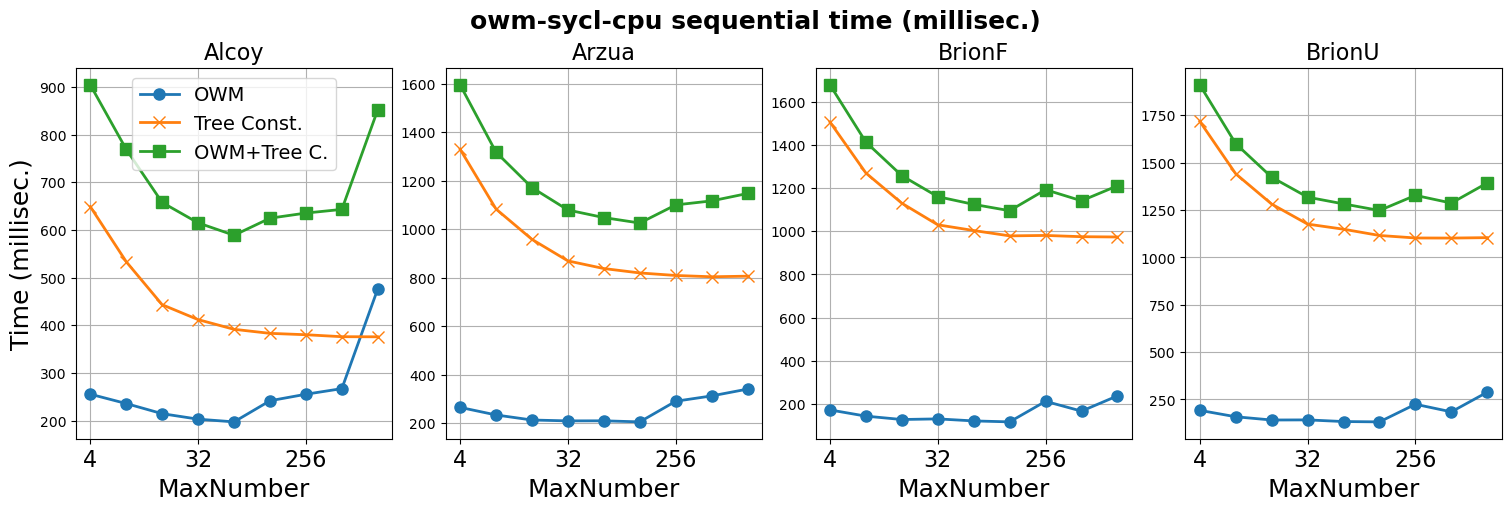

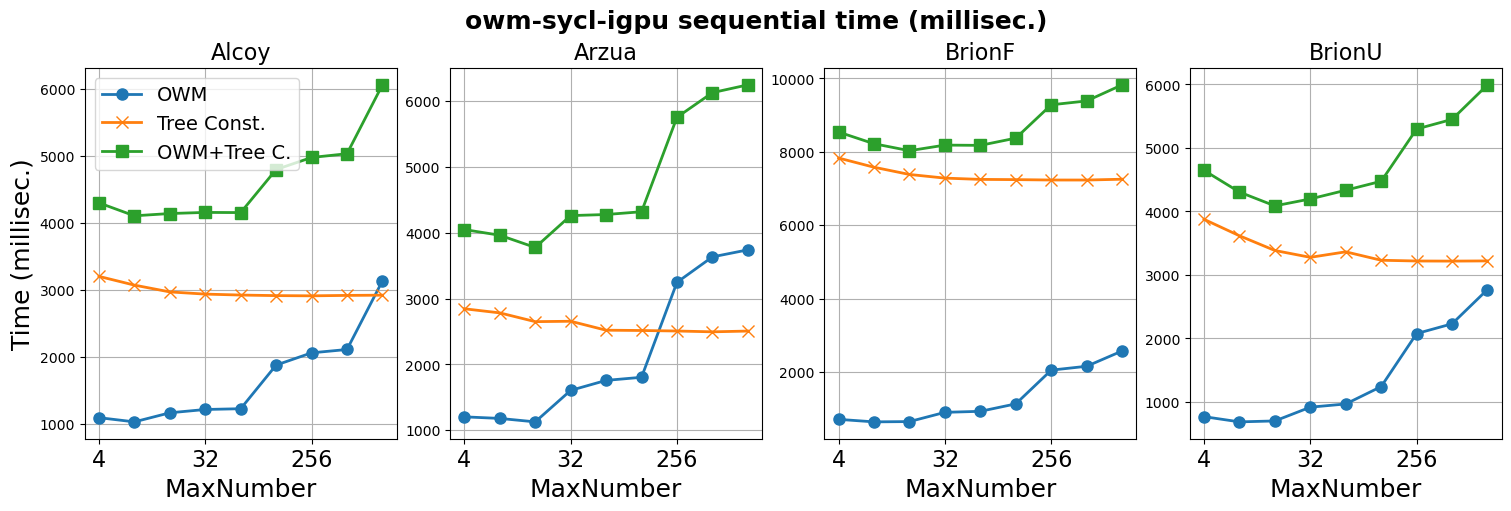

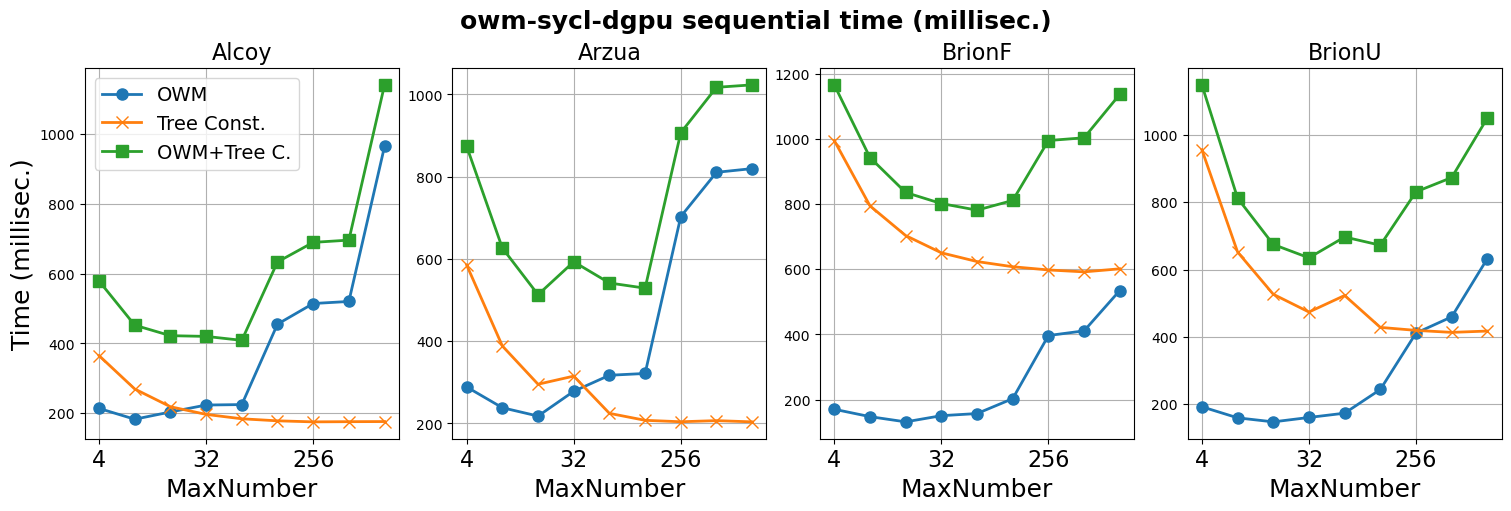

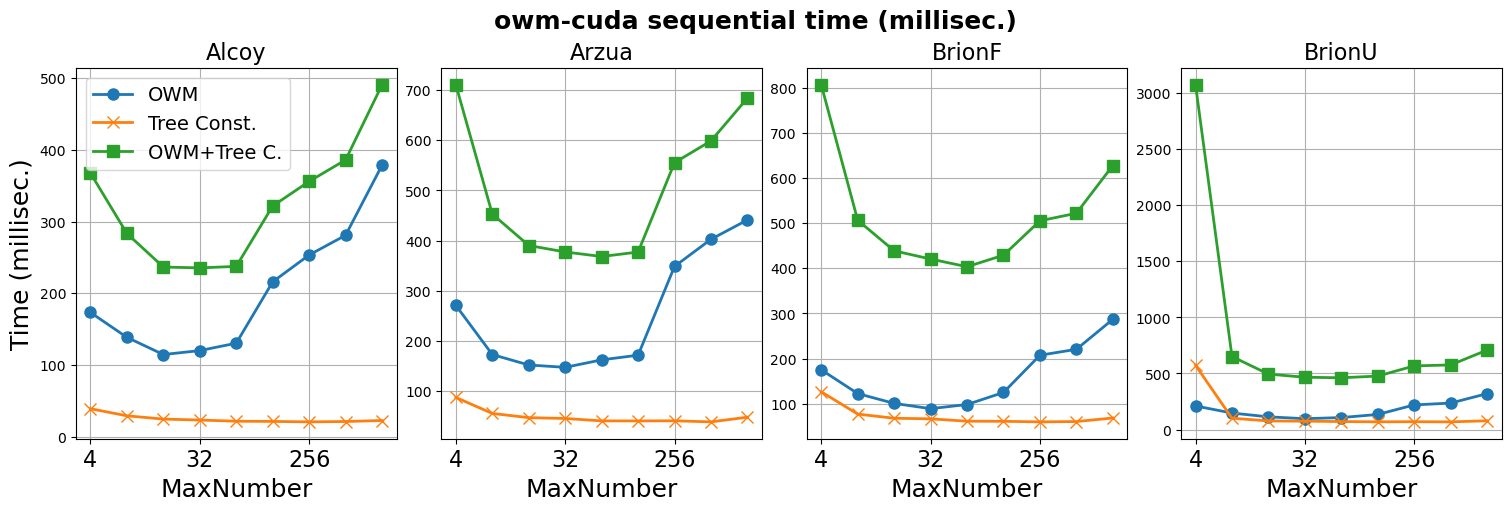

In [4]:
def plot_alltimes(results,version):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    #fig = plt.figure()
    labels=['OWM','Tree Const.','OWM+Tree C.']
    x=list(results[version]['Alcoy'].keys())
    xticks=range(1,len(x)+1)
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True) #sharey=True
    for i,name in zip(range(4),['Alcoy','Arzua','BrionF','BrionU']):
        axs[i].plot(np.array(xticks), np.array([results[version][name][i][3] for i in x]), marks[0], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(xticks), np.array([results[version][name][i][0] for i in x]), marks[1], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(xticks), np.array([results[version][name][i][4] for i in x]), marks[2], linewidth=linew, markersize=markers)

        axs[i].set_title(name,fontsize=16)
        axs[i].set_xlabel('MaxNumber', fontsize=xlabelfs)
        axs[i].set_xticks(ticks=xticks[::3], labels=x[::3],fontsize=xticksfs)
        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()

    fig.suptitle(version + ' sequential time (millisec.)',  fontweight='bold', fontsize=18)
    axs[0].set_ylabel('Time (millisec.)', fontsize=ylabelfs)
    axs[0].legend(labels,loc='best', fontsize= 14)
    #axs[i].show()

plot_alltimes(res,"owm-sycl-cpu")
plot_alltimes(res,"owm-sycl-igpu")
plot_alltimes(res,"owm-sycl-dgpu")
plot_alltimes(res,"owm-cuda")

# Compare CPU-optim 4 with all nomemo versions and MaxNumber=512

In [5]:
import pandas as pd
df=pd.read_csv('All_Optimizations.csv',sep=';')
df=df.drop(df.index[4:28])
df.reset_index(drop=True, inplace=True)
df.insert(4,"Total",0)
df['Total']=df['TimeTree']+df['TimeOWM']
print(df)
base=df.loc[4:7,'TimeTree':'Total']
basea=np.array(base)*1000 #in ms
print(basea)

  Optimization   Cloud  TimeTree   TimeOWM      Total  Level  MinRadMaxNum
0     Baseline   Alcoy  4.737780  3.733700   8.471480      0           0.0
1     Baseline   Arzua  5.749600  4.105800   9.855400      0           0.0
2     Baseline  BrionF  5.971560  6.233900  12.205460      0           0.0
3     Baseline  BrionU  6.761090  7.327300  14.088390      0           0.0
4  Opt4-MinRad   Alcoy  0.167986  0.275714   0.443700      5           1.8
5  Opt4-MinRad   Arzua  0.329102  0.270224   0.599326      5           0.5
6  Opt4-MinRad  BrionF  0.766410  0.276490   1.042900      4           0.1
7  Opt4-MinRad  BrionU  0.866690  0.336850   1.203540      4           0.1
[[ 167.986  275.714  443.7  ]
 [ 329.102  270.224  599.326]
 [ 766.41   276.49  1042.9  ]
 [ 866.69   336.85  1203.54 ]]


In [6]:
mN=512
for ver in res:
    if "nomemo" not in ver.split("-"):
        continue
    print("Version {}".format(ver))
    for cloud, i in zip(res[ver],range(4)):
        treetime=res[ver][cloud][mN][0]
        treesp=basea[i,0]/treetime
        owmtime=res[ver][cloud][mN][3]
        owmsp=basea[i,1]/owmtime
        totaltime=res[ver][cloud][mN][4]
        totalsp=basea[i,2]/totaltime
        print("Cloud {} with maxN={} has TreeC. time={:.2f} ({:.2f}x), OWM time={:.2f} ({:.2f}x) and Total Time={:.2f} ({:.2f}x) in ms.".format(cloud, mN,\
                                    treetime, treesp, owmtime, owmsp, totaltime, totalsp))

Version owm-sycl-cpu-nomemo
Cloud Alcoy with maxN=512 has TreeC. time=374.01 (0.45x), OWM time=255.78 (1.08x) and Total Time=629.79 (0.70x) in ms.
Cloud Arzua with maxN=512 has TreeC. time=802.11 (0.41x), OWM time=327.42 (0.83x) and Total Time=1129.53 (0.53x) in ms.
Cloud BrionF with maxN=512 has TreeC. time=959.54 (0.80x), OWM time=197.57 (1.40x) and Total Time=1157.11 (0.90x) in ms.
Cloud BrionU with maxN=512 has TreeC. time=1084.63 (0.80x), OWM time=227.12 (1.48x) and Total Time=1311.75 (0.92x) in ms.
Version owm-sycl-igpu-nomemo
Cloud Alcoy with maxN=512 has TreeC. time=2915.82 (0.06x), OWM time=2118.08 (0.13x) and Total Time=5033.89 (0.09x) in ms.
Cloud Arzua with maxN=512 has TreeC. time=2493.86 (0.13x), OWM time=3864.68 (0.07x) and Total Time=6358.54 (0.09x) in ms.
Cloud BrionF with maxN=512 has TreeC. time=7227.53 (0.11x), OWM time=2590.74 (0.11x) and Total Time=9818.27 (0.11x) in ms.
Cloud BrionU with maxN=512 has TreeC. time=3218.94 (0.27x), OWM time=2732.09 (0.12x) and Total

In [7]:
df=pd.read_csv('All_Optimizations.csv',sep=';')
df=df.drop(df.index[4:28])
df.reset_index(drop=True, inplace=True)
df.insert(4,"Total",0)
df['Total']=df['TimeTree']+df['TimeOWM']
print(df)
base=df.loc[4:7,'TimeTree':'TimeOWM']
basea=np.array(base)*1000 #in ms
print(basea)
mN=512
for ver in res:
    if "nomemo" not in ver.split("-"):
        continue
    #print("Version {}".format(ver))
    times=np.array([[res[ver][cloud][mN][0],res[ver][cloud][mN][3]] for cloud in res[ver]])
    #for cloud in res[ver]:
        #print("Cloud {} with maxN={} has TreeC. time={:.2f}, OWM time={:.2f} in ms.".format(cloud,\
        #                     mN,res[ver][cloud][mN][0],res[ver][cloud][mN][3]))
    basea=np.hstack((basea,times))
print(basea)


  Optimization   Cloud  TimeTree   TimeOWM      Total  Level  MinRadMaxNum
0     Baseline   Alcoy  4.737780  3.733700   8.471480      0           0.0
1     Baseline   Arzua  5.749600  4.105800   9.855400      0           0.0
2     Baseline  BrionF  5.971560  6.233900  12.205460      0           0.0
3     Baseline  BrionU  6.761090  7.327300  14.088390      0           0.0
4  Opt4-MinRad   Alcoy  0.167986  0.275714   0.443700      5           1.8
5  Opt4-MinRad   Arzua  0.329102  0.270224   0.599326      5           0.5
6  Opt4-MinRad  BrionF  0.766410  0.276490   1.042900      4           0.1
7  Opt4-MinRad  BrionU  0.866690  0.336850   1.203540      4           0.1
[[167.986 275.714]
 [329.102 270.224]
 [766.41  276.49 ]
 [866.69  336.85 ]]
[[ 167.986   275.714   374.015   255.778  2915.82   2118.08    171.456
   528.89     20.8761  279.191 ]
 [ 329.102   270.224   802.111   327.419  2493.86   3864.68    206.457
   856.332    40.1006  416.074 ]
 [ 766.41    276.49    959.539   197.566

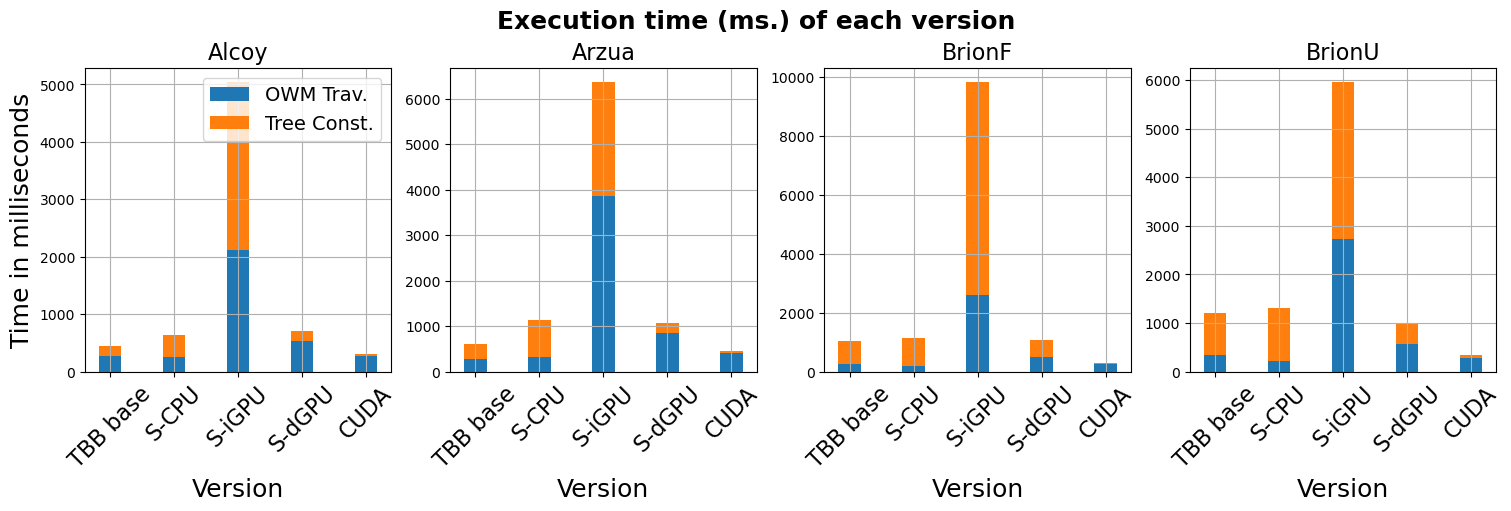

In [8]:
def plot_nomemo(npa):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']


    #fig = plt.figure()
    phases=['OWM Trav.','Tree Const.']
    clouds=['Alcoy','Arzua','BrionF','BrionU']
    versions=['TBB base','S-CPU','S-iGPU','S-dGPU','CUDA']
    x=np.arange(1,len(versions)+1)
    width=0.35
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True)#, sharey=True)
    for i,name in zip(range(len(clouds)),clouds):
        b=np.zeros(len(versions))
        for j,z in zip(phases,reversed(range(len(phases)))): #reversed to have OWM first
            axs[i].bar(x, npa[i][z::2], width, label=j, bottom=b)
            b=b+npa[i][z::2]

        axs[i].set_title(name,fontsize=16)
        axs[i].set_xlabel('Version', fontsize=xlabelfs)
        axs[i].set_xticks(x,labels=versions,fontsize=xticksfs,rotation = 45)
        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()
    fig.suptitle('Execution time (ms.) of each version',  fontweight='bold', fontsize=18)
    
    axs[0].set_ylabel('Time in milliseconds', fontsize=ylabelfs)
    axs[0].legend(phases,loc='best', fontsize= 14)
    pp = PdfPages("Time-nomemo-maxnum512.pdf")
    pp.savefig(fig)
    pp.close()

plot_nomemo(basea)

# Memo vs NoMemo for MaxNumber=512

In [9]:
#memo vs no memo comparison
mN=512
for ver in res:
    if "nomemo" in ver.split("-"):
        continue
    print("Version {}".format(ver))
    for cloud in res[ver]:
        owmtimeNoMemo=res[ver+"-nomemo"][cloud][mN][3]
        owmtimeMemo=res[ver][cloud][mN][3]
        print("Cloud {} with maxN={} has OWM time={:.2f} ms  that is {:.2f}x faster than without memo (time={:.2f} ms)".format(cloud,mN, owmtimeMemo,\
                                                       owmtimeNoMemo/owmtimeMemo, owmtimeNoMemo ))

Version owm-sycl-cpu
Cloud Alcoy with maxN=512 has OWM time=267.12 ms  that is 0.96x faster than without memo (time=255.78 ms)
Cloud Arzua with maxN=512 has OWM time=312.73 ms  that is 1.05x faster than without memo (time=327.42 ms)
Cloud BrionF with maxN=512 has OWM time=166.45 ms  that is 1.19x faster than without memo (time=197.57 ms)
Cloud BrionU with maxN=512 has OWM time=184.73 ms  that is 1.23x faster than without memo (time=227.12 ms)
Version owm-sycl-igpu
Cloud Alcoy with maxN=512 has OWM time=2112.89 ms  that is 1.00x faster than without memo (time=2118.08 ms)
Cloud Arzua with maxN=512 has OWM time=3632.20 ms  that is 1.06x faster than without memo (time=3864.68 ms)
Cloud BrionF with maxN=512 has OWM time=2154.91 ms  that is 1.20x faster than without memo (time=2590.74 ms)
Cloud BrionU with maxN=512 has OWM time=2230.98 ms  that is 1.22x faster than without memo (time=2732.09 ms)
Version owm-sycl-dgpu
Cloud Alcoy with maxN=512 has OWM time=520.48 ms  that is 1.02x faster than

In [10]:
print("\\begin{tabular}{|c|ccc|ccc|ccc|}\hline")
print(" & \multicolumn{3}{c|}{S-CPU}  & \multicolumn{3}{c|}{S-dGPU} & \multicolumn{3}{c|}{CUDA} \\\\ ")  
print(" Cloud &  NM &  M & IMP &  NM &  M & IMP &  NM &  M & IMP \\\\ \hline")
mN=512
versions=res.keys()
clouds=res['owm-sycl-cpu'].keys()
for i in clouds:
    print(i,end='')
    for j in versions:
        if "nomemo" in j.split("-") or "igpu" in j.split("-"):
            continue
        print("& {:0.2f} & {:0.2f} & {:0.2f}x ".format(res[j+"-nomemo"][i][mN][3],res[j][i][mN][3],res[j+"-nomemo"][i][mN][3]/res[j][i][mN][3]),end='')
    print("\\\\ \hline")
print("\\end{tabular}")

\begin{tabular}{|c|ccc|ccc|ccc|}\hline
 & \multicolumn{3}{c|}{S-CPU}  & \multicolumn{3}{c|}{S-dGPU} & \multicolumn{3}{c|}{CUDA} \\ 
 Cloud &  NM &  M & IMP &  NM &  M & IMP &  NM &  M & IMP \\ \hline
Alcoy& 255.78 & 267.12 & 0.96x & 528.89 & 520.48 & 1.02x & 279.19 & 280.86 & 0.99x \\ \hline
Arzua& 327.42 & 312.73 & 1.05x & 856.33 & 810.43 & 1.06x & 416.07 & 402.60 & 1.03x \\ \hline
BrionF& 197.57 & 166.45 & 1.19x & 488.62 & 411.14 & 1.19x & 249.82 & 220.46 & 1.13x \\ \hline
BrionU& 227.12 & 184.73 & 1.23x & 562.68 & 459.71 & 1.22x & 273.56 & 235.54 & 1.16x \\ \hline
\end{tabular}


# Improvement factor when searching for the best maxNumber

In [11]:
mN=512
for ver in res:
    if "nomemo" in ver.split("-"):
        continue
    print("Version {}".format(ver))
    for cloud in res[ver]:
        bestMNtotal=min(res[ver][cloud], key=lambda x: res[ver][cloud][x][4])
        bestTreeTime=res[ver][cloud][bestMNtotal][0]
        bestowmTime=res[ver][cloud][bestMNtotal][3]
        besttotalTime=res[ver][cloud][bestMNtotal][4]
        treetime=res[ver][cloud][mN][0]
        owmtime=res[ver][cloud][mN][3]
        totaltime=res[ver][cloud][mN][4]
        print("Cloud {} with MaxNum={} has TreeC. time={:.2f} ({:.2f}x), OWM time={:.2f} ({:.2f}x) and Total Time={:.2f} ({:.2f}x) in ms.".format(cloud,bestMNtotal,\
                                 bestTreeTime,treetime/bestTreeTime,bestowmTime,owmtime/bestowmTime,besttotalTime,totaltime/besttotalTime))

Version owm-sycl-cpu
Cloud Alcoy with MaxNum=64 has TreeC. time=391.56 (0.96x), OWM time=197.34 (1.35x) and Total Time=588.90 (1.09x) in ms.
Cloud Arzua with MaxNum=128 has TreeC. time=819.53 (0.98x), OWM time=205.72 (1.52x) and Total Time=1025.25 (1.09x) in ms.
Cloud BrionF with MaxNum=128 has TreeC. time=978.60 (1.00x), OWM time=116.68 (1.43x) and Total Time=1095.28 (1.04x) in ms.
Cloud BrionU with MaxNum=128 has TreeC. time=1115.37 (0.99x), OWM time=131.84 (1.40x) and Total Time=1247.21 (1.03x) in ms.
Version owm-sycl-igpu
Cloud Alcoy with MaxNum=8 has TreeC. time=3072.78 (0.95x), OWM time=1033.55 (2.04x) and Total Time=4106.32 (1.23x) in ms.
Cloud Arzua with MaxNum=16 has TreeC. time=2648.79 (0.94x), OWM time=1126.65 (3.22x) and Total Time=3775.44 (1.62x) in ms.
Cloud BrionF with MaxNum=16 has TreeC. time=7380.73 (0.98x), OWM time=647.87 (3.33x) and Total Time=8028.60 (1.17x) in ms.
Cloud BrionU with MaxNum=16 has TreeC. time=3385.11 (0.95x), OWM time=702.29 (3.18x) and Total Time=

In [12]:
print("\\begin{tabular}{|c|cccc|cccc|cccc|}\hline")
print(" & \multicolumn{4}{c|}{S-CPU} &  \multicolumn{4}{c|}{S-dGPU} & \multicolumn{4}{c|}{CUDA} \\\\ ")  
print(" Cloud &  MaxNum & Tree &  OWM & Tot &  MaxNum & Tree &  OWM & Tot &  MaxNum & Tree &  OWM & Tot  \\\\ \hline")
mN=512
versions=res.keys()
clouds=res['owm-sycl-cpu'].keys()
for cloud in clouds:
    print(cloud,end='')
    for ver in versions:
        if "nomemo" in ver.split("-") or "igpu" in ver.split("-"):
            continue
        bestMNtotal=min(res[ver][cloud], key=lambda x: res[ver][cloud][x][4])
        bestTreeTime=res[ver][cloud][bestMNtotal][0]
        bestowmTime=res[ver][cloud][bestMNtotal][3]
        besttotalTime=res[ver][cloud][bestMNtotal][4]
        treetime=res[ver][cloud][mN][0]
        owmtime=res[ver][cloud][mN][3]
        totaltime=res[ver][cloud][mN][4]
        print("& {} & {:0.2f}x & {:0.2f}x & {:0.2f}x ".format(bestMNtotal,treetime/bestTreeTime,owmtime/bestowmTime,totaltime/besttotalTime),end='')
    print("\\\\ \hline")
print("\\end{tabular}")

\begin{tabular}{|c|cccc|cccc|cccc|}\hline
 & \multicolumn{4}{c|}{S-CPU} &  \multicolumn{4}{c|}{S-dGPU} & \multicolumn{4}{c|}{CUDA} \\ 
 Cloud &  MaxNum & Tree &  OWM & Tot &  MaxNum & Tree &  OWM & Tot &  MaxNum & Tree &  OWM & Tot  \\ \hline
Alcoy& 64 & 0.96x & 1.35x & 1.09x & 64 & 0.96x & 2.31x & 1.70x & 32 & 0.91x & 2.34x & 1.64x \\ \hline
Arzua& 128 & 0.98x & 1.52x & 1.09x & 16 & 0.70x & 3.72x & 1.98x & 64 & 0.95x & 2.48x & 1.62x \\ \hline
BrionF& 128 & 1.00x & 1.43x & 1.04x & 64 & 0.95x & 2.61x & 1.28x & 64 & 0.99x & 2.25x & 1.29x \\ \hline
BrionU& 128 & 0.99x & 1.40x & 1.03x & 32 & 0.87x & 2.86x & 1.38x & 64 & 0.96x & 2.21x & 1.25x \\ \hline
\end{tabular}


# Save results in All_Optimizations.csv

In [13]:
output="All_OptimizationsSYCL-CUDA_O3.csv"

f = open(output, "a")

for ver in res:
    #print("Version {}".format(ver))
    for cloud in res[ver]:
        totaltimes=np.array([res[ver][cloud][i][4] for i in res[ver][cloud]])
        bestMNtotal=min(res[ver][cloud], key=lambda x: res[ver][cloud][x][4])
        bestTreeTime=res[ver][cloud][bestMNtotal][0]
        bestowmTime=res[ver][cloud][bestMNtotal][3]
        print("{};{};{:.5f};{:.5f};{};{}".format(ver,cloud,bestTreeTime/1000,bestowmTime/1000,0,bestMNtotal))
        f.write("{};{};{:.5f};{:.5f};{};{}\n".format(ver,cloud,bestTreeTime/1000,bestowmTime/1000,0,bestMNtotal))
f.close()

owm-sycl-cpu;Alcoy;0.39156;0.19734;0;64
owm-sycl-cpu;Arzua;0.81953;0.20572;0;128
owm-sycl-cpu;BrionF;0.97860;0.11668;0;128
owm-sycl-cpu;BrionU;1.11537;0.13184;0;128
owm-sycl-cpu-nomemo;Alcoy;0.39061;0.20861;0;64
owm-sycl-cpu-nomemo;Arzua;0.81597;0.25320;0;128
owm-sycl-cpu-nomemo;BrionF;0.95954;0.19757;0;512
owm-sycl-cpu-nomemo;BrionU;1.08463;0.22712;0;512
owm-sycl-igpu;Alcoy;3.07278;1.03355;0;8
owm-sycl-igpu;Arzua;2.64879;1.12665;0;16
owm-sycl-igpu;BrionF;7.38073;0.64787;0;16
owm-sycl-igpu;BrionU;3.38511;0.70229;0;16
owm-sycl-igpu-nomemo;Alcoy;2.92565;1.39819;0;64
owm-sycl-igpu-nomemo;Arzua;2.51362;2.41186;0;128
owm-sycl-igpu-nomemo;BrionF;7.24851;1.97428;0;64
owm-sycl-igpu-nomemo;BrionU;3.23104;2.28891;0;128
owm-sycl-dgpu;Alcoy;0.18414;0.22489;0;64
owm-sycl-dgpu;Arzua;0.29517;0.21774;0;16
owm-sycl-dgpu;BrionF;0.62363;0.15756;0;64
owm-sycl-dgpu;BrionU;0.47400;0.16094;0;32
owm-sycl-dgpu-nomemo;Alcoy;0.18361;0.26850;0;64
owm-sycl-dgpu-nomemo;Arzua;0.20701;0.48037;0;128
owm-sycl-dgpu-nome